# Bremen Big Data Challenge



---




## Contents

In [ ]:
# Imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Preparing and Exploring data for Darts models

In [ ]:
darts_data = pd.read_csv('/content/bbdc_2023_AWI_data_develop_student.csv', delimiter=';')

darts_data.dropna(axis=0, inplace=True, subset=['Uhrzeit'])
darts_data.drop(darts_data.columns[[7]], inplace=True, axis=1)
darts_data.dropna(axis=0, inplace=True)

# creating a date column for timestamps
darts_data['date'] = pd.to_datetime(darts_data['Datum'] + ' ' +  darts_data['Uhrzeit'], format="%d.%m.%Y %H:%M")

# drop the rows without a time given, since there were no measurements taken


# set the date column as the index and create the timestamps
darts_data.set_index('date', inplace=True)
timestamp_s = darts_data.index.map(pd.Timestamp.timestamp)


darts_data.reset_index(inplace=True)
darts_data['Datum'] = pd.to_datetime(darts_data['Datum'], format="%d.%m.%Y")
# drop the Datum Uhrzeit and NOx columns
darts_data.drop(darts_data.columns[[2]], inplace=True, axis=1)
#darts_data = darts_data.astype('float32')
darts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9144 entries, 0 to 9143
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        9144 non-null   datetime64[ns]
 1   Datum       9144 non-null   datetime64[ns]
 2   SECCI       9144 non-null   object        
 3   Temperatur  9144 non-null   object        
 4   Salinität   9144 non-null   float64       
 5   NO2         9144 non-null   object        
 6   NO3         9144 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 500.2+ KB


In [ ]:
darts_data

,date,Datum,SECCI,Temperatur,Salinität,NO2,NO3
0,1968-01-08 10:10:00,1968-01-08,1.2,3.9,33.275,0.18,11.36
1,1968-01-12 09:40:00,1968-01-12,0.9,1.8,30.203,0.27,21.21
2,1968-01-15 09:40:00,1968-01-15,1.4,2.1,31.732,0.16,21.5
3,1968-01-22 09:20:00,1968-01-22,1.6,3.5,32.097,0.21,19.21
4,1968-02-02 10:05:00,1968-02-02,1.0,3.2,31.234,0.25,4.5
...,...,...,...,...,...,...,...
9139,2010-12-21 09:25:00,2010-12-21,2.6,4.0,30.861,0.52,18.85
9140,2010-12-22 08:15:00,2010-12-22,2.7,4.2,31.643,0.44,12.98
9141,2010-12-28 08:30:00,2010-12-28,1.9,2.9,30.137,0.81,26.1
9142,2010-12-29 08:15:00,2010-12-29,2.0,2.1,30.273,0.79,26.73


**Preparing additional weather data from Helgoland**

In [ ]:
def read_csv_weather(file):
    df = pd.read_csv(file, delimiter=';')
    df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format="%Y%m%d")
    df.set_index('MESS_DATUM', inplace=True)
    timestamp_s = df.index.map(pd.Timestamp.timestamp)
    df.reset_index(inplace=True)
    df = df.replace(-999, pd.NA)
    
    return df

In [ ]:
helgoland_weather = read_csv_weather('/content/produkt_klima_tag_19520501_20211231_02115.txt')
helgoland_weather.drop(helgoland_weather.columns[[1,18]], inplace=True, axis=1)

helgoland_weather = helgoland_weather.fillna(helgoland_weather.mean())

#helgoland_weather.drop(helgoland_weather.columns[[1,2,4]], inplace=True, axis=1)
helgoland_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25427 entries, 0 to 25426
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MESS_DATUM  25427 non-null  datetime64[ns]
 1   QN_3        25427 non-null  float64       
 2     FX        25427 non-null  float64       
 3     FM        25427 non-null  float64       
 4   QN_4        25427 non-null  float64       
 5    RSK        25427 non-null  float64       
 6   RSKF        25427 non-null  float64       
 7    SDK        25427 non-null  float64       
 8   SHK_TAG     25427 non-null  float64       
 9     NM        25427 non-null  float64       
 10   VPM        25427 non-null  float64       
 11    PM        25427 non-null  float64       
 12   TMK        25427 non-null  float64       
 13   UPM        25427 non-null  float64       
 14   TXK        25427 non-null  float64       
 15   TNK        25427 non-null  float64       
 16   TGK        25427 non-

<ipython-input-5-5e20c134e8fa>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  helgoland_weather = helgoland_weather.fillna(helgoland_weather.mean())


In [ ]:
helgoland_weather.drop(helgoland_weather.columns[[1,2,3,4,6,8,9,10,13,15,16]], inplace=True, axis=1)

In [ ]:
helgoland_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25427 entries, 0 to 25426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MESS_DATUM  25427 non-null  datetime64[ns]
 1    RSK        25427 non-null  float64       
 2    SDK        25427 non-null  float64       
 3     PM        25427 non-null  float64       
 4    TMK        25427 non-null  float64       
 5    TXK        25427 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.2 MB


**Merge Data with Helgoland weather data**

In [ ]:
darts_data_helgo = pd.merge(darts_data, helgoland_weather, how="inner", left_on='Datum', right_on='MESS_DATUM')
darts_data_helgo.set_index('date', inplace=True)
darts_data.set_index('date', inplace=True)
darts_data.drop(darts_data.columns[[0]], inplace=True, axis=1)

In [ ]:
darts_data_helgo.drop(darts_data_helgo.columns[[0,6]], inplace=True, axis=1)

In [ ]:
darts_data_helgo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9144 entries, 1968-01-08 10:10:00 to 2010-12-30 08:30:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SECCI       9144 non-null   object 
 1   Temperatur  9144 non-null   object 
 2   Salinität   9144 non-null   float64
 3   NO2         9144 non-null   object 
 4   NO3         9144 non-null   object 
 5    RSK        9144 non-null   float64
 6    SDK        9144 non-null   float64
 7     PM        9144 non-null   float64
 8    TMK        9144 non-null   float64
 9    TXK        9144 non-null   float64
dtypes: float64(6), object(4)
memory usage: 785.8+ KB


# Exploratory Data Analysis

**Heatmap of correlation**

<ipython-input-23-aa4da99548db>:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


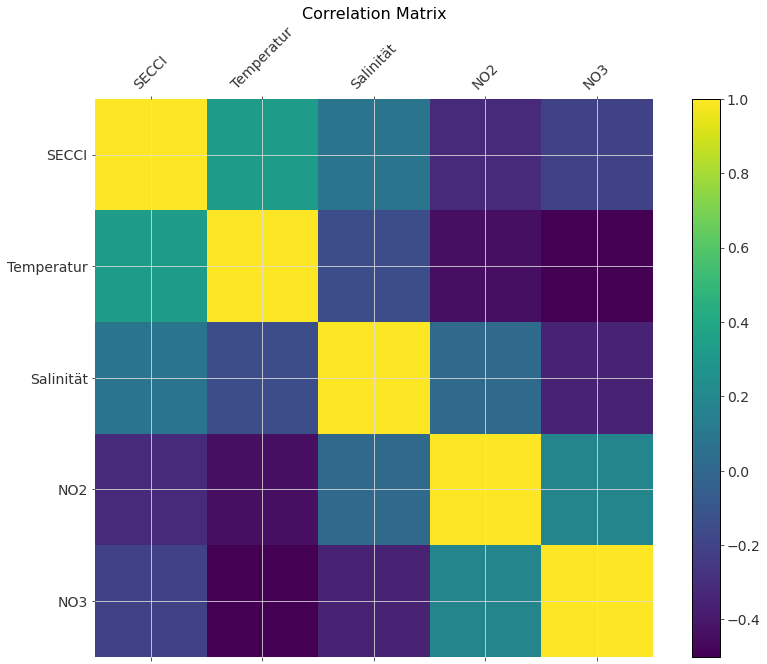

In [ ]:
f = plt.figure(figsize=(14, 10))
plt.matshow(darts_data.corr(), fignum=f.number)
plt.xticks(range(darts_data.select_dtypes(['number']).shape[1]), darts_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(darts_data.select_dtypes(['number']).shape[1]), darts_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
# to better understand the correlation heatmap above
corr = darts_data.corr()
corr.style.background_gradient(cmap='RdBu_r').set_precision(3)

<ipython-input-16-e6843cf79775>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='RdBu_r').set_precision(3)


,SECCI,Temperatur,Salinität,NO2,NO3
SECCI,1.000,0.322,0.077,-0.320,-0.206
Temperatur,0.322,1.000,-0.139,-0.439,-0.500
Salinität,0.077,-0.139,1.000,0.020,-0.348
NO2,-0.320,-0.439,0.020,1.000,0.182
NO3,-0.206,-0.500,-0.348,0.182,1.000


**Visualising parameters for selected years**

In [ ]:
subset_data_plot = darts_data.loc['2007-01-03':]

In [ ]:
#function to plot the data
def plot_data(data, column = None):
  fig, ax = plt.subplots(figsize=(25,10))
  ax.plot(data.index, data[column])


  ax.legend()
  ax.set_xlabel('Year')
  ax.set_ylabel(column)

  fig.tight_layout()

<AxesSubplot:xlabel='date'>

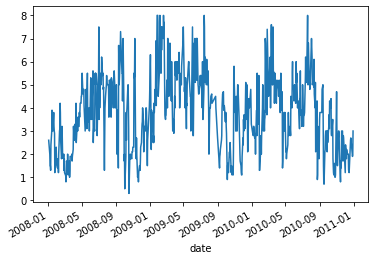

In [ ]:
subset_data_plot['SECCI'].plot()

**Sechi plot**

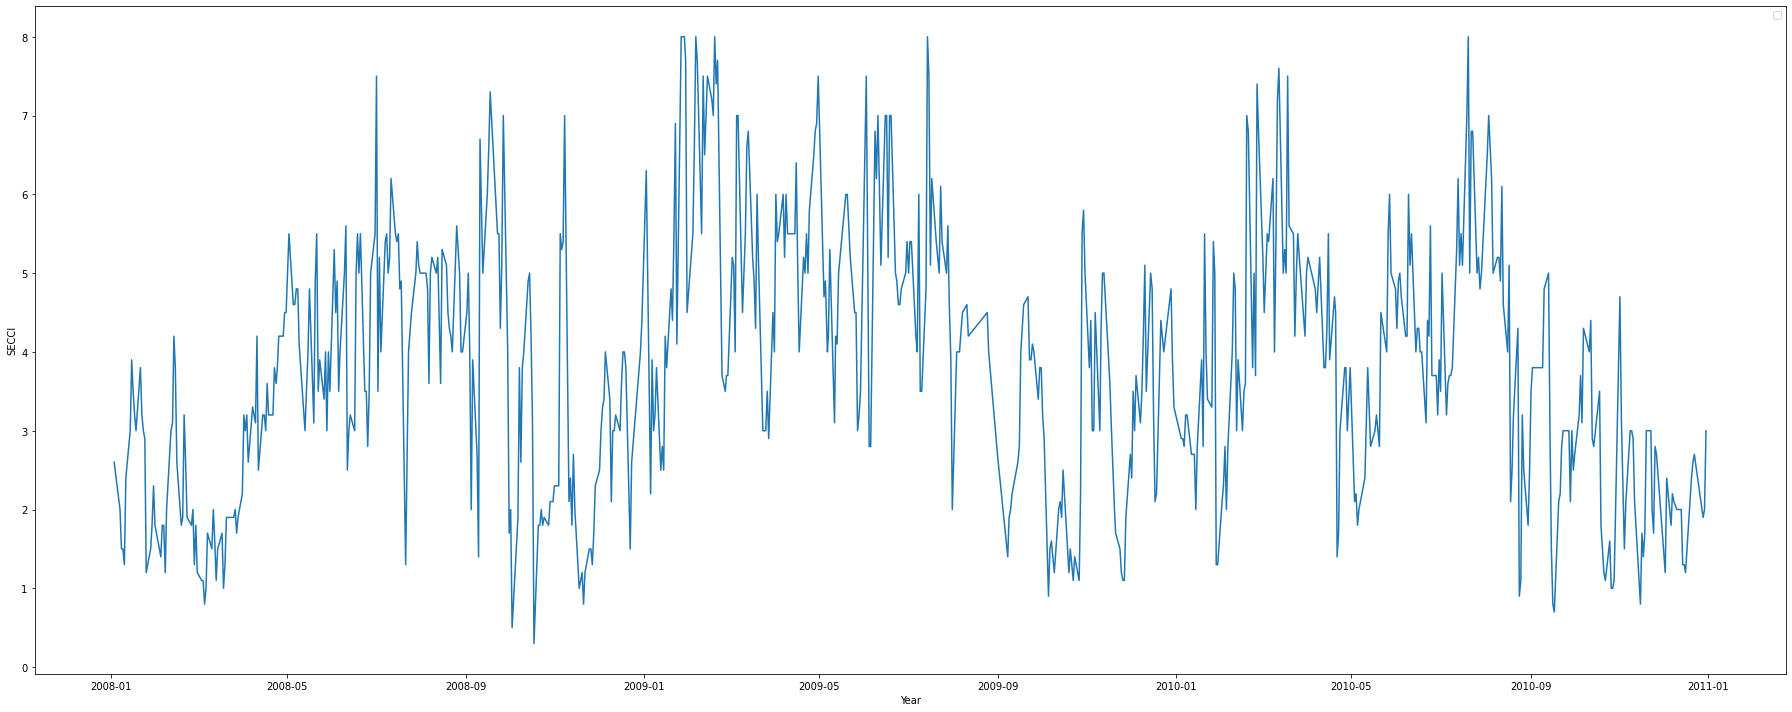

In [ ]:
plot_data(subset_data_plot, 'SECCI')

**Temperatur plot**

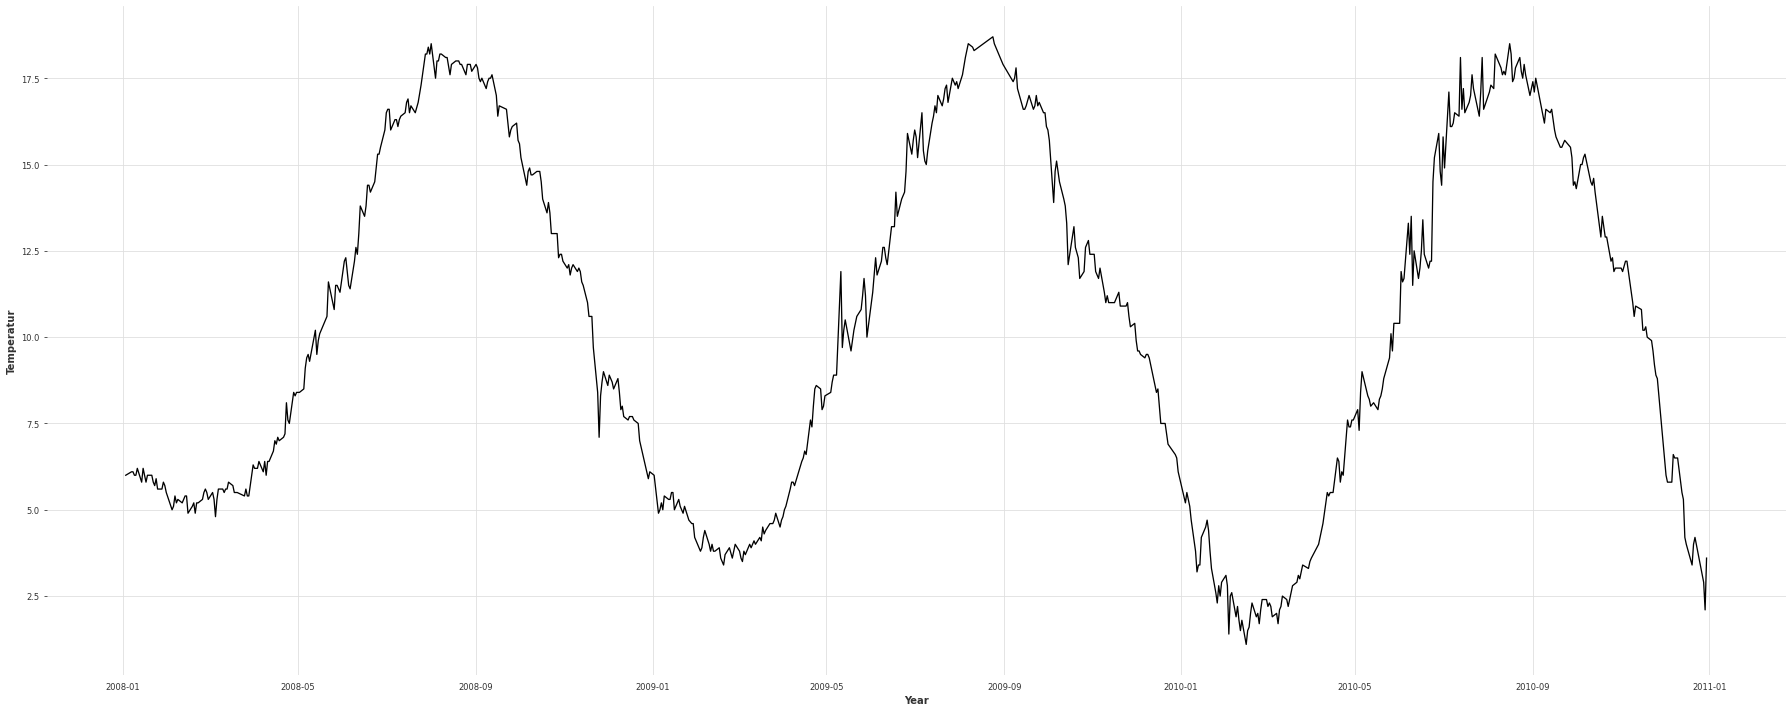

In [ ]:
plot_data(subset_data_plot, 'Temperatur')

**Salinität plot**

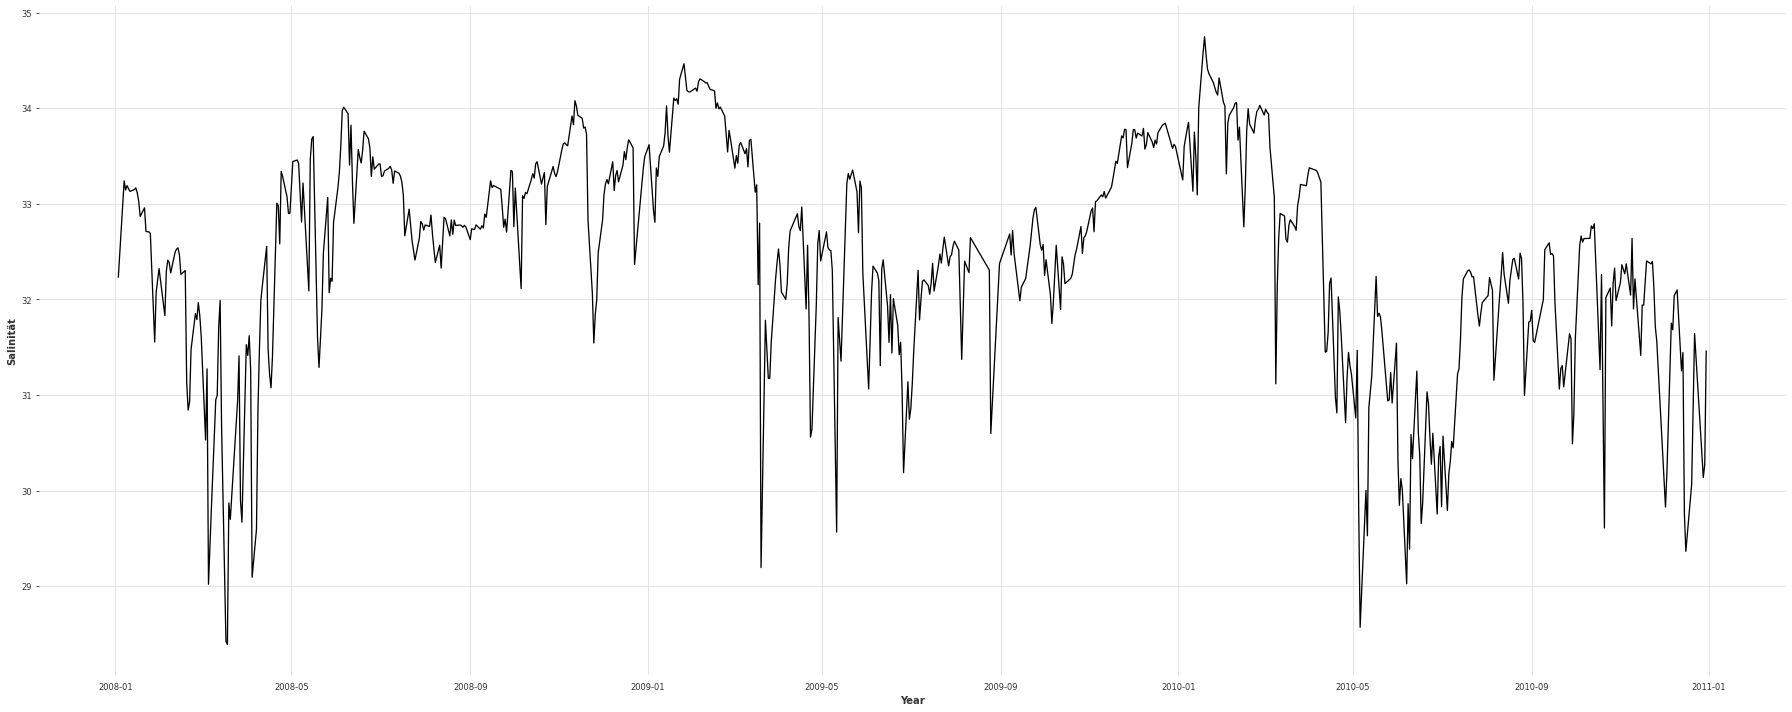

In [ ]:
plot_data(subset_data_plot, 'Salinität')

**NO2 plot**

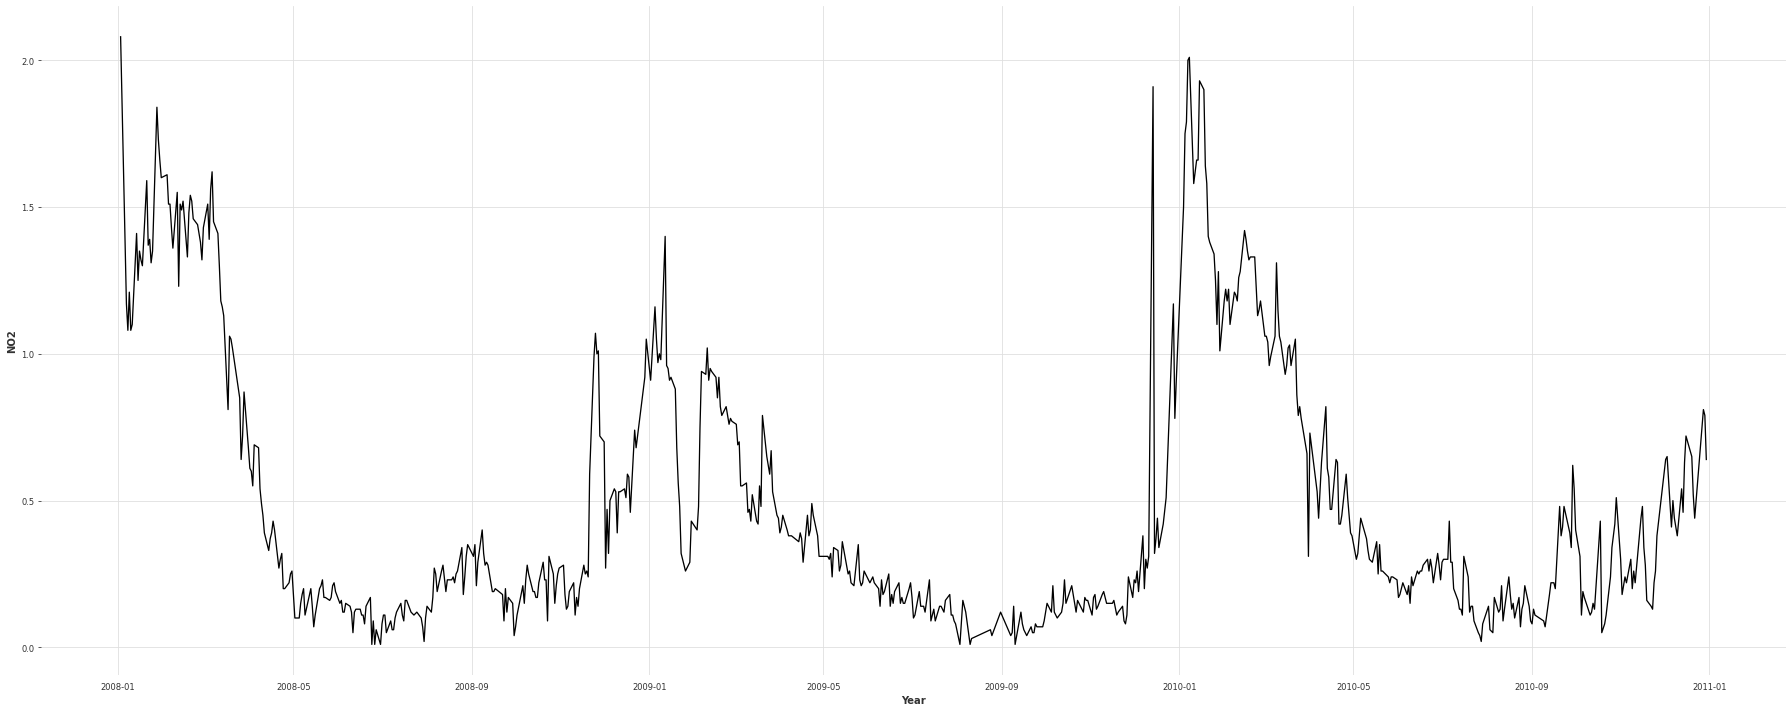

In [ ]:
plot_data(subset_data_plot, 'NO2')

**NO3 plot**

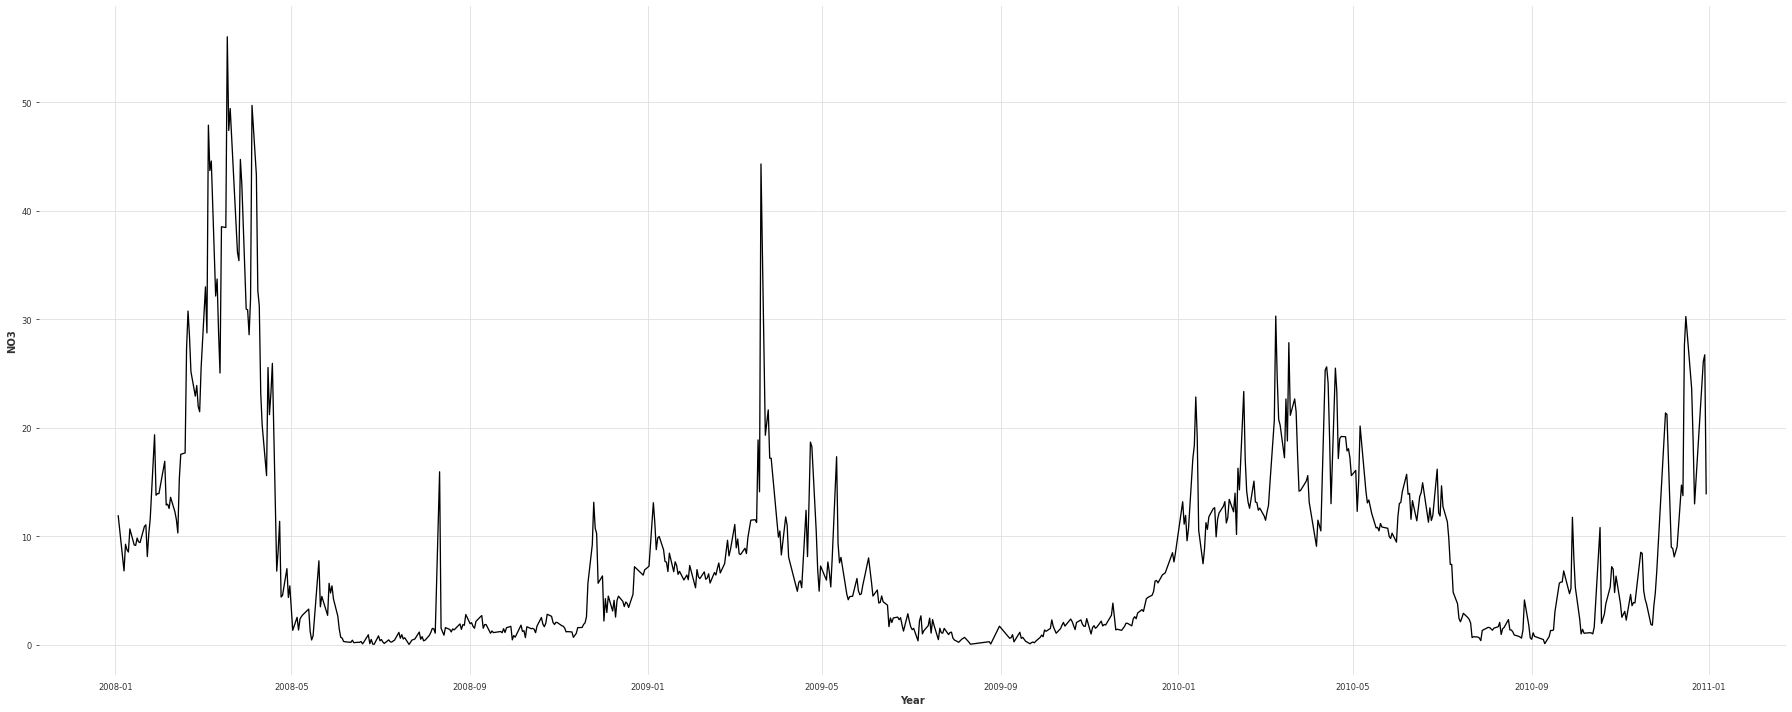

In [ ]:
plot_data(subset_data_plot, 'NO3')

# The Darts model

**For the NOx data**

In [ ]:
temp_df = pd.DataFrame({'date':darts_data.index, 'temp':darts_data['Temperatur']})
temp_series = TimeSeries.from_dataframe(temp_df, 'date', 'temp', fill_missing_dates=True, freq='d')

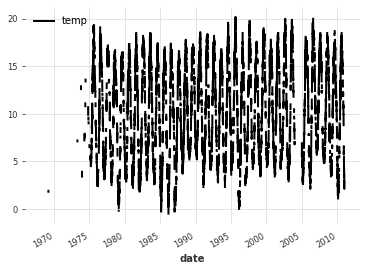

In [ ]:
temp_series.plot()

In [ ]:
filler = MissingValuesFiller()
filled_temp_series = filler.transform(temp_series)

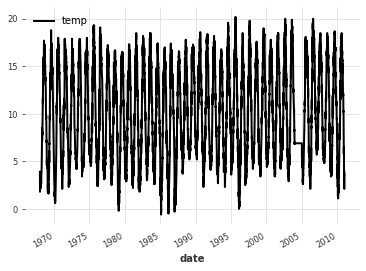

In [ ]:
filled_temp_series.plot()

In [ ]:
train, val = filled_temp_series.split_before(pd.Timestamp('2000-01-01'))

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(30)

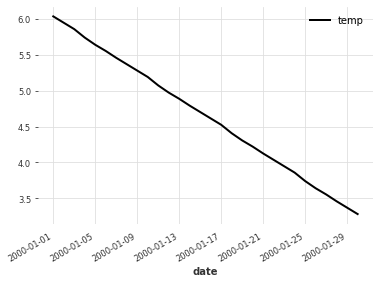

In [ ]:
prediction.plot()

In [ ]:
filled_temp_series.plot(label="actual")
prediction.plot(label="forecast")
plt.legend()

In [ ]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

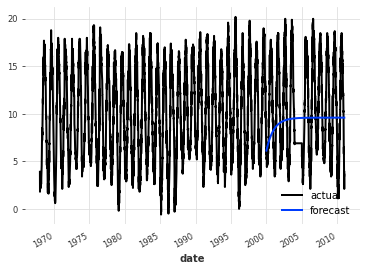

In [ ]:
filled_temp_series.plot(label="actual")
prediction_aarima.plot(label="forecast")
plt.legend()

# Back to Tensorflow again

In [ ]:
day = 24*60*60
year = (365.2425)*day
def add_time_features(data):  

  data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
  data['year'] = data.index.year
  data['year_mod'] = (data['year'] - data['year'].min()) / (2013 - data['year'].min())
  data.drop(columns=['year'], inplace=True, axis=1)
  data = data.astype('float32')
  return data

In [ ]:
darts_data = add_time_features(darts_data)

In [ ]:
darts_data_helgo = add_time_features(darts_data_helgo)

In [ ]:
darts_data.drop(darts_data.columns[[9]], inplace=True, axis=1)

In [ ]:
darts_data_helgo

,SECCI,Temperatur,Salinität,NO2,NO3,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,,,,,,
1968-01-08 10:10:00,1.2,3.9,33.275002,0.18,11.360000,0.0,2.4,1015.400024,-2.0,2.4,0.461749,-0.887011,0.118568,0.992946,0.000000
1968-01-12 09:40:00,0.9,1.8,30.202999,0.27,21.209999,0.0,5.5,1021.000000,-5.2,-4.0,0.573576,-0.819152,0.186207,0.982511,0.000000
1968-01-15 09:40:00,1.4,2.1,31.732000,0.16,21.500000,0.0,1.1,992.400024,6.1,6.8,0.573576,-0.819152,0.236642,0.971597,0.000000
1968-01-22 09:20:00,1.6,3.5,32.097000,0.21,19.209999,0.1,0.0,1029.800049,1.8,5.0,0.642788,-0.766044,0.351421,0.936217,0.000000
1968-02-02 10:05:00,1.0,3.2,31.233999,0.25,4.500000,0.2,4.9,1010.599976,3.4,4.5,0.480989,-0.876727,0.521712,0.853121,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,2.6,4.0,30.861000,0.52,18.850000,0.0,0.5,1005.799988,-0.8,1.9,0.625923,-0.779884,-0.180497,0.983576,0.933333
2010-12-22 08:15:00,2.7,4.2,31.643000,0.44,12.980000,1.7,0.1,1008.099976,-1.8,-0.3,0.831470,-0.555570,-0.164376,0.986398,0.933333
2010-12-28 08:30:00,1.9,2.9,30.136999,0.81,26.100000,0.0,3.3,1022.000000,-2.9,-0.9,0.793353,-0.608761,-0.061690,0.998095,0.933333


# Exploring autocorrelation and trend

**Exploring the autocorrelation**

In [ ]:
def get_yearly_autocorr(data):
    ac = acf(data, nlags=366)
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366])

sub_sechi_data = darts_data['SECCI']
sub_temp_data = darts_data['Temperatur']
sub_salin_data = darts_data['Salinität']
sub_no2_data = darts_data['NO2']
sub_no3_data = darts_data['NO3']

secchi_autocorr = get_yearly_autocorr(sub_sechi_data)
temp_autocorr = get_yearly_autocorr(sub_temp_data)
salin_autocorr = get_yearly_autocorr(sub_salin_data)
no2_autocorr = get_yearly_autocorr(sub_no2_data)
no3_autocorr = get_yearly_autocorr(sub_no3_data)


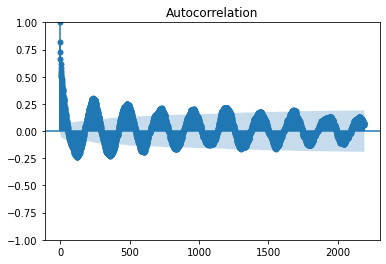

In [ ]:
plot_acf(sub_sechi_data, lags=6*365)
plt.show()

In [ ]:
secchi_autocorr

-0.21140537316002572

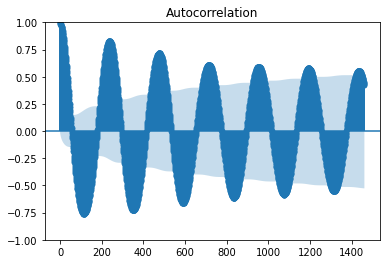

In [ ]:
plot_acf(sub_temp_data, lags=4*365)
plt.show()

In [ ]:
temp_autocorr

-0.6888855538110198

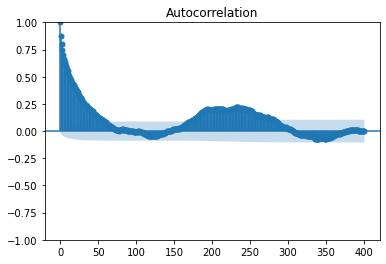

In [ ]:
plot_acf(sub_salin_data, lags=400)
plt.show()

In [ ]:
salin_autocorr

-0.025016250272551548

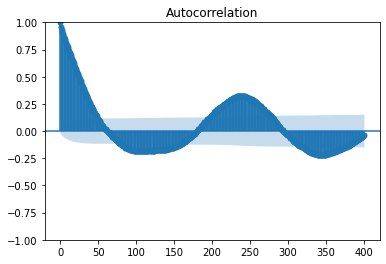

In [ ]:
plot_acf(sub_no2_data, lags=400)
plt.show()

In [ ]:
no2_autocorr

-0.17985339241132503

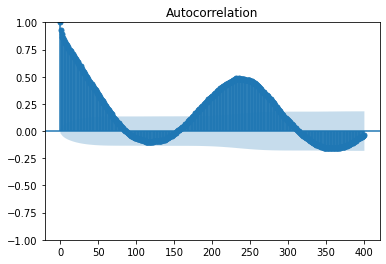

In [ ]:
plot_acf(sub_no3_data, lags=400)
plt.show()

In [ ]:
no3_autocorr

-0.15626594816740746

**Explore the trend**

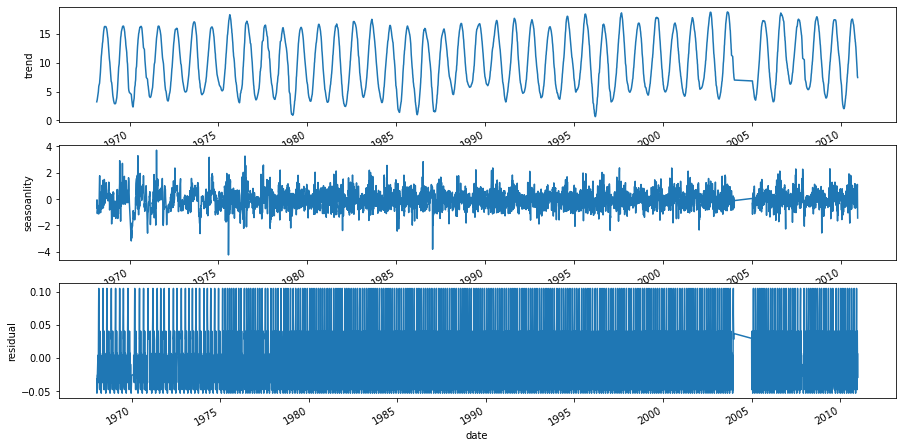

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(sub_temp_data, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

# Train Validation split

**Classic train/validation split**

In [ ]:
n = len(darts_data)
train_df = darts_data.loc[:'1999-12-30']
val_df = darts_data.loc['2000-01-01':]

num_train_samples = len(train_df)
num_val_samples = len(val_df)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()


train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
darts_data_df_normalised = (darts_data - train_mean) / train_std

In [ ]:
darts_data_df_normalised

,SECCI,Temperatur,Salinität,NO2,NO3,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,
1968-01-08 10:10:00,-1.227409,-1.232105,0.980436,-0.951134,-0.384647,-1.883767,-1.597644,0.180874,1.445087,-1.984953
1968-01-12 09:40:00,-1.393425,-1.650698,-1.469230,-0.830588,0.221080,-1.296080,-1.335581,0.276128,1.430258,-1.984953
1968-01-15 09:40:00,-1.116732,-1.590899,-0.249979,-0.977922,0.238914,-1.296080,-1.335581,0.347155,1.414750,-1.984953
1968-01-22 09:20:00,-1.006055,-1.311837,0.041078,-0.910952,0.098090,-0.932355,-1.130484,0.508796,1.364476,-1.984953
1968-02-02 10:05:00,-1.338086,-1.371637,-0.647093,-0.857376,-0.806503,-1.782655,-1.557928,0.748612,1.246398,-1.984953
...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,-0.452670,-1.212172,-0.944529,-0.495737,0.075952,-1.020981,-1.183933,-0.240291,1.431771,2.900804
2010-12-22 08:15:00,-0.397331,-1.172306,-0.320950,-0.602889,-0.285025,0.059224,-0.317655,-0.217588,1.435782,2.900804
2010-12-28 08:30:00,-0.840039,-1.431435,-1.521859,-0.107310,0.521792,-0.141088,-0.523074,-0.072979,1.452404,2.900804


**Walk forward split**

In [ ]:
def normalise_data(data):  
  mean = data.mean()
  std = data.std()

  data_normalised = (data - mean) / std
  return mean, std, data_normalised

In [ ]:
#walk_forward_normalised_standard = normalise_data(darts_data)
mean, std, walk_forward_helgo = normalise_data(darts_data_helgo)

In [ ]:
walk_forward_helgo

,SECCI,Temperatur,Salinität,NO2,NO3,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,,,,,,
1968-01-08 10:10:00,-1.270157,-1.266042,0.952879,-0.856573,-0.299032,-0.481117,-0.546039,0.173178,-2.046949,-1.504755,-1.787031,-1.671699,0.171857,1.442236,-1.917133
1968-01-12 09:40:00,-1.432804,-1.683296,-1.522836,-0.737681,0.336425,-0.481117,0.134419,0.711152,-2.603203,-2.565982,-1.243703,-1.413486,0.267206,1.427424,-1.917133
1968-01-15 09:40:00,-1.161726,-1.623688,-0.290620,-0.882993,0.355134,-0.481117,-0.831393,-2.036370,-0.638932,-0.775161,-1.243703,-1.413486,0.338304,1.411933,-1.917133
1968-01-22 09:20:00,-1.053295,-1.345519,0.003532,-0.816942,0.207398,-0.456816,-1.072846,1.556549,-1.386398,-1.073631,-0.907433,-1.211403,0.500105,1.361715,-1.917133
1968-02-02 10:05:00,-1.378588,-1.405127,-0.691957,-0.764101,-0.741594,-0.432514,0.002717,-0.287950,-1.108271,-1.156540,-1.693550,-1.632566,0.740161,1.243767,-1.917133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,-0.511140,-1.246173,-0.992556,-0.407425,0.184174,-0.481117,-0.963095,-0.749072,-1.838354,-1.587663,-0.989370,-1.264066,-0.249727,1.428936,1.714076
2010-12-22 08:15:00,-0.456924,-1.206435,-0.362345,-0.513107,-0.194520,-0.067993,-1.050896,-0.528118,-2.012183,-1.952460,0.009298,-0.410517,-0.227002,1.432942,1.714076
2010-12-28 08:30:00,-0.890648,-1.464735,-1.576025,-0.024329,0.651896,-0.481117,-0.348487,0.807220,-2.203395,-2.051950,-0.175894,-0.612917,-0.082248,1.449546,1.714076


**Creating reduced datasets for each parameter**

# Predicting the new values

In [ ]:
sechi_model = keras.models.load_model('sechi_lstm-5.keras')
temp_model = keras.models.load_model('temp_lstm-5.keras')
salin_model = keras.models.load_model('salin_lstm-5.keras')
no2_model = keras.models.load_model('no2_lstm_2-5.keras')
no3_model = keras.models.load_model('no3_lstm-7.keras')

In [ ]:
final_predictions = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = prediction_dates.tail(-1)
prediction_dates['date'] = pd.to_datetime(prediction_dates['Datum'] + ' ' +  prediction_dates['Uhrzeit'], format="%d.%m.%Y %H:%M")

prediction_dates.set_index('date', inplace=True)
timestamp = prediction_dates.index.map(pd.Timestamp.timestamp)


prediction_dates['Datum'] = pd.to_datetime(prediction_dates['Datum'], format="%d.%m.%Y")
prediction_dates['Day sin'] = np.sin(timestamp * (2 * np.pi / day))
prediction_dates['Day cos'] = np.cos(timestamp * (2 * np.pi / day))
prediction_dates['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
prediction_dates['Year cos'] = np.cos(timestamp * (2 * np.pi / year))
prediction_dates['year'] = prediction_dates.index.year
prediction_dates['year_mod'] = (prediction_dates['year'] - 1968) / (2013 - 1968)
prediction_dates['Datum'] = pd.to_datetime(prediction_dates['Datum'], format="%d.%m.%Y")
prediction_dates.drop(prediction_dates.columns[[1,2,3,4,5,6,7,12]], inplace=True, axis=1)
prediction_dates.reset_index(inplace=True)

In [ ]:
prediction_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      914 non-null    datetime64[ns]
 1   Datum     914 non-null    datetime64[ns]
 2   Day sin   914 non-null    float64       
 3   Day cos   914 non-null    float64       
 4   Year sin  914 non-null    float64       
 5   Year cos  914 non-null    float64       
 6   year_mod  914 non-null    float64       
dtypes: datetime64[ns](2), float64(5)
memory usage: 50.1 KB


In [ ]:
predict_dates_helgo = pd.merge(prediction_dates, helgoland_weather, how="inner", left_on='Datum', right_on='MESS_DATUM')
predict_dates_helgo.set_index('date', inplace=True)
predict_dates_helgo.drop(predict_dates_helgo.columns[[0,6]], axis=1, inplace=True)

In [ ]:
sub_for_04 = darts_data_helgo.loc['2005-01-03':]

In [ ]:
sub_for_04.drop(sub_for_04.columns[[0,1,2,3,4]], inplace=True, axis=1)

<ipython-input-26-1da73c48e396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_for_04.drop(sub_for_04.columns[[0,1,2,3,4]], inplace=True, axis=1)


In [ ]:
sub_for_04

,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,
2005-01-03 08:25:00,1.0,1.2,1018.500000,6.7,7.6,0.806445,-0.591310,0.049235,0.998787,0.822222
2005-01-04 08:30:00,0.6,0.2,1015.500000,7.6,8.2,0.793353,-0.608761,0.066468,0.997789,0.822222
2005-01-05 08:45:00,3.2,0.0,1016.799988,6.3,7.0,0.751840,-0.659346,0.083801,0.996482,0.822222
2005-01-06 08:45:00,0.0,5.0,1018.000000,7.1,8.3,0.751840,-0.659346,0.100930,0.994894,0.822222
2005-01-10 07:50:00,2.9,3.5,1011.500000,8.4,9.6,0.887011,-0.461749,0.168449,0.985710,0.822222
...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,0.0,0.5,1005.799988,-0.8,1.9,0.625923,-0.779884,-0.180497,0.983576,0.933333
2010-12-22 08:15:00,1.7,0.1,1008.099976,-1.8,-0.3,0.831470,-0.555570,-0.164376,0.986398,0.933333
2010-12-28 08:30:00,0.0,3.3,1022.000000,-2.9,-0.9,0.793353,-0.608761,-0.061690,0.998095,0.933333


In [ ]:
sub_for_04 = (sub_for_04 - mean[5:]) / std[5:]
predict_dates_helgo = (predict_dates_helgo - mean[5:]) / std[5:]

In [ ]:
sub_for_04

,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,
2005-01-03 08:25:00,-0.238103,-0.809443,0.470984,-0.534635,-0.642507,-0.112289,-0.546511,0.074120,1.450528,1.281789
2005-01-04 08:30:00,-0.335309,-1.028946,0.182782,-0.378189,-0.543017,-0.175894,-0.612917,0.098414,1.449110,1.281789
2005-01-05 08:45:00,0.296528,-1.072846,0.307669,-0.604167,-0.741998,-0.377592,-0.805399,0.122847,1.447256,1.281789
2005-01-06 08:45:00,-0.481117,0.024668,0.422951,-0.465103,-0.526436,-0.377592,-0.805399,0.146994,1.445001,1.281789
2005-01-10 07:50:00,0.223624,-0.304586,-0.201487,-0.239125,-0.310874,0.279151,-0.053511,0.242174,1.431966,1.281789
...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,-0.481117,-0.963095,-0.749072,-1.838354,-1.587663,-0.989370,-1.264066,-0.249727,1.428936,1.714076
2010-12-22 08:15:00,-0.067993,-1.050896,-0.528118,-2.012183,-1.952460,0.009298,-0.410517,-0.227002,1.432942,1.714076
2010-12-28 08:30:00,-0.481117,-0.348487,0.807220,-2.203395,-2.051950,-0.175894,-0.612917,-0.082248,1.449546,1.714076


In [ ]:
predict_dates_helgo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 2004-01-02 07:34:00 to 2013-12-30 08:40:00
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0     PM      914 non-null    float64
 1    RSK      914 non-null    float64
 2    SDK      914 non-null    float64
 3    TMK      914 non-null    float64
 4    TXK      914 non-null    float64
 5   Day cos   914 non-null    float64
 6   Day sin   914 non-null    float64
 7   Year cos  914 non-null    float64
 8   Year sin  914 non-null    float64
 9   year_mod  914 non-null    float64
dtypes: float64(10)
memory usage: 78.5 KB


**Predict data for 681 model**

In [ ]:
for_predicting_04_681 = pd.concat([predict_dates_helgo[:233], sub_for_04[:448]], ignore_index=True)

for_predicting_11_13_681 = predict_dates_helgo.loc['2011-01-03':]

In [ ]:
for_predicting_04_681

,PM,RSK,SDK,TMK,TXK,Day cos,Day sin,Year cos,Year sin,year_mod
0,0.893680,-0.481117,-0.787493,-1.525462,-1.587663,0.186212,0.425148,1.452009,0.030668,1.195332
1,0.480591,-0.165199,-1.072846,-1.768822,-1.571082,-1.505720,-6.641013,1.448285,0.109991,1.195332
2,-0.230307,0.515241,-1.072846,-0.951825,-0.741998,-1.045192,-0.670696,1.446718,0.129042,1.195332
3,0.000254,-0.481117,-0.941145,-0.656315,-0.741998,-0.612917,-0.175894,1.444418,0.152592,1.195332
4,-0.681823,1.317188,-1.050896,-0.917059,-1.007304,-0.987136,-0.594932,1.441585,0.177187,1.195332
...,...,...,...,...,...,...,...,...,...,...
676,-2.218900,0.004911,-0.897244,0.751701,0.584537,0.718667,0.662568,0.571551,-1.299485,1.368246
677,-0.518508,-0.140897,0.551474,0.838616,0.667445,0.638720,0.634019,0.594139,-1.290055,1.368246
678,-1.248623,-0.067993,-0.897244,1.116743,1.081987,0.324381,0.497774,0.616792,-1.280136,1.368246
679,0.153963,-0.432514,-1.072846,0.560489,0.468465,-1.872161,-5.692227,0.709660,-1.234380,1.368246


**Predict data for 365 model**

In [ ]:
for_predicting_04 = predict_dates_helgo[:365]
for_predicting_11 = predict_dates_helgo.loc['2011-01-03':][:365]
for_predicting_12 = predict_dates_helgo.loc['2012-01-02':][:365]
for_predicting_13 = predict_dates_helgo.tail(365)

In [ ]:
def predict_parameters(data_for_predicting, model, idx, mean_predict, std_predict, output_length, is_04):

  data_for_predicting = data_for_predicting.to_numpy().reshape((1, output_length, 10)) 
  predictions = model.predict(data_for_predicting)
  predictions = predictions * std_predict[idx] + mean_predict[idx]
  predictions = predictions.reshape(output_length,1)
  if is_04:
    predictions = np.insert(predictions, 0, 0,axis=0)
  return predictions

# Predictions year wise


In [ ]:
# predictions 2004
results_sechi_04 = pd.DataFrame(predict_parameters(for_predicting_04, sechi_model, 0, mean, std, True)[:234], columns = ['SECCI']).round(3)
results_temp_04 = pd.DataFrame(predict_parameters(for_predicting_04, temp_model, 1, mean, std, True)[:234], columns = ['Temperatur']).round(3)
results_salin_04 = pd.DataFrame(predict_parameters(for_predicting_04, salin_model, 2, mean, std, True)[:234], columns = ['Salinität']).round(3)
results_no2_04 = pd.DataFrame(predict_parameters(for_predicting_04, no2_model, 3, mean, std, True)[:234], columns = ['NO2']).round(3)
results_no3_04 = pd.DataFrame(predict_parameters(for_predicting_04, no3_model, 4, mean, std, True)[:234], columns = ['NO3']).round(3)

predictions_nox_04 = results_no2_04['NO2'] + results_no3_04['NO3']
results_nox_04 = pd.DataFrame(predictions_nox_04, columns = ['NOx'])

1/1 [==============================] - 1s 917ms/step


1/1 [==============================] - 1s 1s/step


In [ ]:
# predictions 2011
results_sechi_11 = pd.DataFrame(predict_parameters(for_predicting_11, sechi_model, 0, mean, std, False)[:230], columns = ['SECCI']).round(3)
results_temp_11 = pd.DataFrame(predict_parameters(for_predicting_11, temp_model, 1, mean, std, False)[:230], columns = ['Temperatur']).round(3)
results_salin_11 = pd.DataFrame(predict_parameters(for_predicting_11, salin_model, 2, mean, std, False)[:230], columns = ['Salinität']).round(3)
results_no2_11 = pd.DataFrame(predict_parameters(for_predicting_11, no2_model, 3, mean, std, False)[:230], columns = ['NO2']).round(3)
results_no3_11 = pd.DataFrame(predict_parameters(for_predicting_11, no3_model, 4, mean, std, False)[:230], columns = ['NO3']).round(3)

predictions_nox_11 = results_no2_11['NO2'] + results_no3_11['NO3']
results_nox_11 = pd.DataFrame(predictions_nox_11, columns = ['NOx'])

1/1 [==============================] - 0s 85ms/step


In [ ]:
# predictions 2012
results_sechi_12 = pd.DataFrame(predict_parameters(for_predicting_12, sechi_model, 0, mean, std, False)[:228], columns = ['SECCI']).round(3)
results_temp_12 = pd.DataFrame(predict_parameters(for_predicting_12, temp_model, 1, mean, std, False)[:228], columns = ['Temperatur']).round(3)
results_salin_12 = pd.DataFrame(predict_parameters(for_predicting_12, salin_model, 2, mean, std, False)[:228], columns = ['Salinität']).round(3)
results_no2_12 = pd.DataFrame(predict_parameters(for_predicting_12, no2_model, 3, mean, std, False)[:228], columns = ['NO2']).round(3)
results_no3_12 = pd.DataFrame(predict_parameters(for_predicting_12, no3_model, 4, mean, std, False)[:228], columns = ['NO3']).round(3)

predictions_nox_12 = results_no2_12['NO2'] + results_no3_12['NO3']
results_nox_12 = pd.DataFrame(predictions_nox_04, columns = ['NOx'])

1/1 [==============================] - 0s 61ms/step


In [ ]:
# predictions 2013
results_sechi_13 = pd.DataFrame(predict_parameters(for_predicting_13, sechi_model, 0, mean, std, False)[141:], columns = ['SECCI']).round(3)
results_temp_13 = pd.DataFrame(predict_parameters(for_predicting_13, temp_model, 1, mean, std, False)[141:], columns = ['Temperatur']).round(3)
results_salin_13 = pd.DataFrame(predict_parameters(for_predicting_13, salin_model, 2, mean, std, False)[141:], columns = ['Salinität']).round(3)
results_no2_13 = pd.DataFrame(predict_parameters(for_predicting_13, no2_model, 3, mean, std, False)[141:], columns = ['NO2']).round(3)
results_no3_13 = pd.DataFrame(predict_parameters(for_predicting_13, no3_model, 4, mean, std, False)[141:], columns = ['NO3']).round(3)

predictions_nox_13 = results_no2_13['NO2'] + results_no3_13['NO3']
results_nox_13 = pd.DataFrame(predictions_nox_13, columns = ['NOx'])

1/1 [==============================] - 0s 61ms/step


In [ ]:
final_sechi = pd.DataFrame(pd.concat([results_sechi_04['SECCI'], results_sechi_11['SECCI'], results_sechi_12['SECCI'], results_sechi_13['SECCI']],ignore_index=True),columns=['SECCI'])
final_temp = pd.DataFrame(pd.concat([results_temp_04['Temperatur'], results_temp_11['Temperatur'], results_temp_12['Temperatur'], results_temp_13['Temperatur']],ignore_index=True),columns=['Temperatur'])
final_salin = pd.DataFrame(pd.concat([results_salin_04['Salinität'], results_salin_11['Salinität'], results_salin_12['Salinität'], results_salin_13['Salinität']],ignore_index=True),columns=['Salinität'])
final_no2 = pd.DataFrame(pd.concat([results_no2_04['NO2'], results_no2_11['NO2'], results_no2_12['NO2'], results_no2_13['NO2']],ignore_index=True),columns=['NO2'])
final_no3 = pd.DataFrame(pd.concat([results_no3_04['NO3'], results_no3_11['NO3'], results_no3_12['NO3'], results_no3_13['NO3']],ignore_index=True),columns=['NO3'])
final_nox = pd.DataFrame(pd.concat([results_nox_04['NOx'], results_nox_11['NOx'], results_nox_12['NOx'], results_nox_13['NOx']],ignore_index=True),columns=['NOx'])
final_frame = pd.concat([final_sechi, final_temp, final_salin, final_no2, final_no3, final_nox], axis=1).round(2)

In [ ]:
final_frame.head(914)

,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,0.00,0.00,0.000000,0.00,0.00,0.00
1,6.23,7.06,32.169998,0.35,14.64,14.99
2,6.30,6.90,32.160000,0.35,14.26,14.61
3,6.35,6.80,32.169998,0.34,13.64,13.98
4,6.41,6.61,32.189999,0.32,13.32,13.64
...,...,...,...,...,...,...
909,5.51,7.27,32.639999,0.21,0.90,2.72
910,5.42,7.10,32.680000,0.20,1.24,2.51
911,5.37,7.05,32.700001,0.19,1.21,2.18
912,5.35,6.96,32.730000,0.18,0.93,1.57


In [ ]:
subset_data_plot['NOx'] = subset_data_plot['NO2'] + subset_data_plot['NO3']

<ipython-input-66-162f9397469f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data_plot['NOx'] = subset_data_plot['NO2'] + subset_data_plot['NO3']


<AxesSubplot:xlabel='date'>

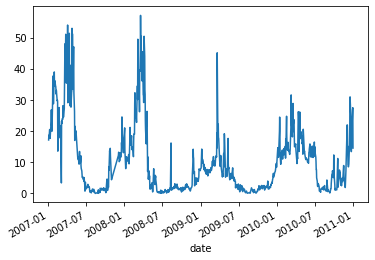

In [ ]:
subset_data_plot['NOx'].plot()

In [ ]:
final_frame.tail(-1)['Salinität'].plot()

NameError: ignored

# Predictions in 681 steps


In [ ]:
# predictions 2004
results_sechi_04 = pd.DataFrame(predict_parameters(for_predicting_04_681, sechi_model, 0, mean, std, 681, True)[:234], columns = ['SECCI']).round(3)
results_temp_04 = pd.DataFrame(predict_parameters(for_predicting_04_681, temp_model, 1, mean, std, 681, True)[:234], columns = ['Temperatur']).round(3)
results_salin_04 = pd.DataFrame(predict_parameters(for_predicting_04_681, salin_model, 2, mean, std, 681, True)[:234], columns = ['Salinität']).round(3)
results_no2_04 = pd.DataFrame(predict_parameters(for_predicting_04_681, no2_model, 3, mean, std, 681, True)[:234], columns = ['NO2']).round(3)
results_no3_04 = pd.DataFrame(predict_parameters(for_predicting_04_681, no3_model, 4, mean, std, 681, True)[:234], columns = ['NO3']).round(3)

predictions_nox_04 = results_no2_04['NO2'] + results_no3_04['NO3']
results_nox_04 = pd.DataFrame(predictions_nox_04, columns = ['NOx'])

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


In [ ]:
# predictions 2011-2013
results_sechi_11_13 = pd.DataFrame(predict_parameters(for_predicting_11_13_681, sechi_model, 0, mean, std, 681, False), columns = ['SECCI']).round(3)
results_temp_11_13 = pd.DataFrame(predict_parameters(for_predicting_11_13_681, temp_model, 1, mean, std, 681, False), columns = ['Temperatur']).round(3)
results_salin_11_13 = pd.DataFrame(predict_parameters(for_predicting_11_13_681, salin_model, 2, mean, std, 681, False), columns = ['Salinität']).round(3)
results_no2_11_13 = pd.DataFrame(predict_parameters(for_predicting_11_13_681, no2_model, 3, mean, std, 681, False), columns = ['NO2']).round(3)
results_no3_11_13 = pd.DataFrame(predict_parameters(for_predicting_11_13_681, no3_model, 4, mean, std, 681, False), columns = ['NO3']).round(3)

predictions_nox_11_13 = results_no2_11_13['NO2'] + results_no3_11_13['NO3']
results_nox_11_13 = pd.DataFrame(predictions_nox_11_13, columns = ['NOx'])

1/1 [==============================] - 0s 134ms/step


In [ ]:
final_sechi_681 = pd.DataFrame(pd.concat([results_sechi_04['SECCI'], results_sechi_11_13['SECCI']],ignore_index=True),columns=['SECCI'])
final_temp_681 = pd.DataFrame(pd.concat([results_temp_04['Temperatur'], results_temp_11_13['Temperatur']],ignore_index=True),columns=['Temperatur'])
final_salin_681 = pd.DataFrame(pd.concat([results_salin_04['Salinität'], results_salin_11_13['Salinität']],ignore_index=True),columns=['Salinität'])
final_no2_681 = pd.DataFrame(pd.concat([results_no2_04['NO2'], results_no2_11_13['NO2']],ignore_index=True),columns=['NO2'])
final_no3_681 = pd.DataFrame(pd.concat([results_no3_04['NO3'], results_no3_11_13['NO3']],ignore_index=True),columns=['NO3'])
final_nox_681 = pd.DataFrame(pd.concat([results_nox_04['NOx'], results_nox_11_13['NOx']],ignore_index=True),columns=['NOx'])
final_frame_681 = pd.concat([final_sechi_681, final_temp_681, final_salin_681, final_no2_681, final_no3_681, final_nox_681], axis=1).round(2)

In [ ]:
final_frame_681

,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,0.00,0.00,0.000000,0.00,0.00,0.00
1,2.39,5.63,32.250000,0.86,8.43,9.29
2,2.40,5.52,32.250000,0.84,8.70,9.55
3,2.40,5.30,32.240002,0.81,8.85,9.66
4,2.44,5.11,32.230000,0.78,9.00,9.79
...,...,...,...,...,...,...
910,3.13,6.92,32.810001,0.22,10.88,11.10
911,3.05,6.72,32.810001,0.24,11.07,11.32
912,3.00,6.57,32.790001,0.28,10.85,11.12
913,2.98,6.44,32.779999,0.31,10.76,11.07


<Axes: xlabel='date'>

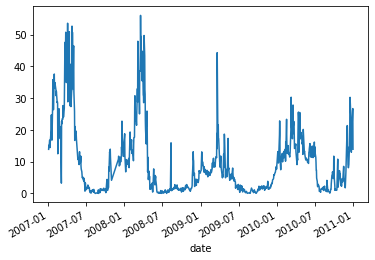

In [ ]:
subset_data_plot['NO3'].plot()

<Axes: >

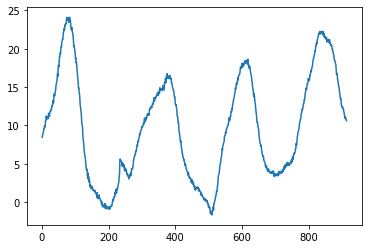

In [ ]:
final_frame_681.tail(-1)['NO3'].plot()

# Other predictions


**Generating the predictions for 2011-2013**

In [ ]:
def reshape_for_predicting(data, n_param, two_four):
  if two_four:
    data = data.loc[:'2003-12-31']
  for_predicting = data.tail(2*365)
  for_predicting = for_predicting.to_numpy().reshape((1, 2*365, n_param))
  return for_predicting

In [ ]:
mean_11_13 = mean
std_11_13 = std

In [ ]:
for_predicting_11_13_sechi = reshape_for_predicting(sechi_reduced,6,False)
for_predicting_11_13_temp = reshape_for_predicting(temp_reduced, 8,False)
for_predicting_11_13_salin = reshape_for_predicting(salin_reduced, 6,False)
for_predicting_11_13_no2 = reshape_for_predicting(no2_reduced, 8,False)
for_predicting_11_13_no3 = reshape_for_predicting(no3_reduced, 8,False)

In [ ]:
# Sechi predictions
predictions_sechi_11_13 = sechi_model.predict(for_predicting_11_13_sechi)
predictions_sechi_11_13 = predictions_sechi_11_13 * std_11_13[0] + mean_11_13[0]
predictions_sechi_11_13 = predictions_sechi_11_13.reshape(3*365,1)
#predictions_sechi_11_13 = predictions_sechi_11_13[365:]
results_sechi_11_13 = pd.DataFrame(predictions_sechi_11_13, columns = ['SECCI']).round(3)

# Temperatur predictions
predictions_temp_11_13 = temp_model.predict(for_predicting_11_13_temp)
predictions_temp_11_13 = predictions_temp_11_13 * std_11_13[1] + mean_11_13[1]
predictions_temp_11_13 = predictions_temp_11_13.reshape(3*365,1)
#predictions_temp_11_13 = predictions_temp_11_13[365:]
results_temp_11_13 = pd.DataFrame(predictions_temp_11_13, columns = ['Temperatur']).round(3)

# Salinität predictions
predictions_salin_11_13 = salin_model.predict(for_predicting_11_13_salin)
predictions_salin_11_13 = predictions_salin_11_13 * std_11_13[2] + mean_11_13[2]
predictions_salin_11_13 = predictions_salin_11_13.reshape(3*365,1)
#predictions_salin_11_13 = predictions_salin_11_13[365:]
results_salin_11_13 = pd.DataFrame(predictions_salin_11_13, columns = ['Salinität']).round(3)

# NO2 predictions
predictions_no2_11_13 = no2_model.predict(for_predicting_11_13_no2)
predictions_no2_11_13 = predictions_no2_11_13 * std_11_13[3] + mean_11_13[3]
predictions_no2_11_13 = predictions_no2_11_13.reshape(3*365,1)
#predictions_no2_11_13 = predictions_no2_11_13[365:]
results_no2_11_13 = pd.DataFrame(predictions_no2_11_13, columns = ['NO2']).round(3)

# NO3 predicitions
predictions_no3_11_13 = no3_model.predict(for_predicting_11_13_no3)
predictions_no3_11_13 = predictions_no3_11_13 * std_11_13[4] + mean_11_13[4]
predictions_no3_11_13 = predictions_no3_11_13.reshape(3*365,1)
#predictions_no3_11_13 = predictions_no3_11_13[365:]
results_no3_11_13 = pd.DataFrame(predictions_no3_11_13, columns = ['NO3']).round(3)


1/1 [==============================] - 1s 1s/step


In [ ]:
predictions_nox_11_13 = results_no2_11_13['NO2'] + results_no3_11_13['NO3']
results_nox_11_13 = pd.DataFrame(predictions_nox_11_13, columns = ['NOx'])

**Generating predictions for 2011**

In [ ]:
mean_11 = mean
std_11 = std
pred_length = 3*365

In [ ]:
for_predicting_11_sechi = reshape_for_predicting(sechi_reduced,6)
for_predicting_11_temp = reshape_for_predicting(temp_reduced, 8)
for_predicting_11_salin = reshape_for_predicting(salin_reduced, 6)
for_predicting_11_no2 = reshape_for_predicting(no2_reduced, 8)
for_predicting_11_no3 = reshape_for_predicting(no3_reduced, 8)

In [ ]:
# Sechi predictions
predictions_sechi_11 = sechi_model.predict(for_predicting_11_sechi)
predictions_sechi_11 = (predictions_sechi_11 * std_11[0] + mean_11[0])
predictions_sechi_11 = predictions_sechi_11.reshape(pred_length,1)
#predictions_sechi_11 = predictions_sechi_11[:233]
predictions_sechi_11 = np.insert(predictions_sechi_11, 0, 0,axis=0)
results_sechi_11 = pd.DataFrame(predictions_sechi_11, columns = ['SECCI']).round(3)

# Temperatur predictions
predictions_temp_11 = temp_model.predict(for_predicting_11_temp)
predictions_temp_11 = (predictions_temp_11 * std_11[1] + mean_11[1])
predictions_temp_11 = predictions_temp_11.reshape(pred_length,1)
#predictions_temp_11 = predictions_temp_11[:233]
predictions_temp_11 = np.insert(predictions_temp_11, 0, 0,axis=0)
results_temp_11 = pd.DataFrame(predictions_temp_11, columns = ['Temperatur']).round(3)

# Salinität predictions
predictions_salin_11 = salin_model.predict(for_predicting_11_salin)
predictions_salin_11 = (predictions_salin_11 * std_11[2] + mean_11[2])
predictions_salin_11 = predictions_salin_11.reshape(pred_length,1)
#predictions_salin_11 = predictions_salin_11[:233]
predictions_salin_11 = np.insert(predictions_salin_11, 0, 0,axis=0)
results_salin_11 = pd.DataFrame(predictions_salin_11, columns = ['Salinität']).round(3)

# NO2 predictions
predictions_no2_11 = no2_model.predict(for_predicting_11_no2)
predictions_no2_11 = (predictions_no2_11 * std_11[3] + mean_11[3])
predictions_no2_11 = predictions_no2_11.reshape(pred_length,1)
#predictions_no2_11 = predictions_no2_04[:233]
predictions_no2_11 = np.insert(predictions_no2_11, 0, 0,axis=0)
results_no2_11 = pd.DataFrame(predictions_no2_11, columns = ['NO2']).round(3)

# NO3 predicitions
predictions_no3_11 = no3_model.predict(for_predicting_11_no3)
predictions_no3_11 = (predictions_no3_11 * std_11[4] + mean_11[4])
predictions_no3_11 = predictions_no3_11.reshape(pred_length,1)
#predictions_no3_11 = predictions_no3_11[:233]
predictions_no3_11 = np.insert(predictions_no3_11, 0, 0,axis=0)
results_no3_11 = pd.DataFrame(predictions_no3_11, columns = ['NO3']).round(3)

NameError: ignored

In [ ]:
predictions_nox_11 = results_no2_11['NO2'] + results_no3_11['NO3']
results_nox_11 = pd.DataFrame(predictions_nox_11, columns = ['NOx'])

**Generating the predictions for 2004**

In [ ]:
mean_04 = mean
std_04 = std

In [ ]:
for_predicting_04_sechi = reshape_for_predicting(sechi_reduced,6, True)
for_predicting_04_temp = reshape_for_predicting(temp_reduced, 8, True)
for_predicting_04_salin = reshape_for_predicting(salin_reduced, 6, True)
for_predicting_04_no2 = reshape_for_predicting(no2_reduced, 8, True)
for_predicting_04_no3 = reshape_for_predicting(no3_reduced, 8, True)

In [ ]:
# Sechi predictions
predictions_sechi_04 = sechi_model.predict(for_predicting_04_sechi)
predictions_sechi_04 = (predictions_sechi_04 * std_04[0] + mean_04[0])
predictions_sechi_04 = predictions_sechi_04.reshape(pred_length,1)
predictions_sechi_04 = predictions_sechi_04[:365]
predictions_sechi_04 = np.insert(predictions_sechi_04, 0, 0,axis=0)
results_sechi_04 = pd.DataFrame(predictions_sechi_04, columns = ['SECCI']).round(3)

# Temperatur predictions
predictions_temp_04 = temp_model.predict(for_predicting_04_temp)
predictions_temp_04 = (predictions_temp_04 * std_04[1] + mean_04[1])
predictions_temp_04 = predictions_temp_04.reshape(pred_length,1)
predictions_temp_04 = predictions_temp_04[:365]
predictions_temp_04 = np.insert(predictions_temp_04, 0, 0,axis=0)
results_temp_04 = pd.DataFrame(predictions_temp_04, columns = ['Temperatur']).round(3)

# Salinität predictions
predictions_salin_04 = salin_model.predict(for_predicting_04_salin)
predictions_salin_04 = (predictions_salin_04 * std_04[2] + mean_04[2])
predictions_salin_04 = predictions_salin_04.reshape(pred_length,1)
predictions_salin_04 = predictions_salin_04[:365]
predictions_salin_04 = np.insert(predictions_salin_04, 0, 0,axis=0)
results_salin_04 = pd.DataFrame(predictions_salin_04, columns = ['Salinität']).round(3)

# NO2 predictions
predictions_no2_04 = no2_model.predict(for_predicting_04_no2)
predictions_no2_04 = (predictions_no2_04 * std_04[3] + mean_04[3])
predictions_no2_04 = predictions_no2_04.reshape(pred_length,1)
predictions_no2_04 = predictions_no2_04[:365]
predictions_no2_04 = np.insert(predictions_no2_04, 0, 0,axis=0)
results_no2_04 = pd.DataFrame(predictions_no2_04, columns = ['NO2']).round(3)

# NO3 predicitions
predictions_no3_04 = no3_model.predict(for_predicting_04_no3)
predictions_no3_04 = (predictions_no3_04 * std_04[4] + mean_04[4])
predictions_no3_04 = predictions_no3_04.reshape(pred_length,1)
predictions_no3_04 = predictions_no3_04[:365]
predictions_no3_04 = np.insert(predictions_no3_04, 0, 0,axis=0)
results_no3_04 = pd.DataFrame(predictions_no3_04, columns = ['NO3']).round(3)

1/1 [==============================] - 0s 48ms/step


In [ ]:
predictions_nox_04 = results_no2_04['NO2'] + results_no3_04['NO3']
results_nox_04 = pd.DataFrame(predictions_nox_04, columns = ['NOx'])

**Generating the final dataframe**

In [ ]:
final_predictions = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = pd.to_datetime(final_predictions['Datum'], format="%d.%m.%Y")

In [ ]:
def predictions_per_day(pred_secchi, pred_temp, pred_salin, pred_no2, pred_no3, pred_nox, dates_to_predict, start_date, end_date):
  actual_dates = pd.date_range(start=start_date, end=end_date, freq='D')
  df_actual_dates = pd.DataFrame(pd.concat([actual_dates, pred_secchi, pred_temp, pred_salin, pred_no2, pred_no3, pred_nox], ignore_index=True, axis=1),columns=['date', 'SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3', 'NOx'])
  df_dates_to_predict = pd.DataFrame([dates_to_predict],columns=['date'])
  final_frame = pd.merge(df_dates_to_predict, df_actual_dates, on='date', how='inner')
  return final_frame

In [ ]:
final_04 = predictions_per_day(results_sechi_04,results_temp_04,results_salin_04,results_no2_04,results_no3_04,results_nox_04,prediction_dates.loc[:'2004-12-30'],'2004-01-01','2004-12-31')
final_11 = predictions_per_day(prediction_dates.loc[:'2004-12-30'],'2004-01-01','2004-12-31')
final_12 = predictions_per_day(results_sechi_11_13,results_temp_11_13,results_salin_11_13,results_no2_11_13,results_no3_11_13,results_nox_11_13,prediction_dates.loc['2004-12-30':],'2011-01-01','2013-12-31')

In [ ]:
final_sechi = pd.DataFrame(pd.concat([results_sechi_04['SECCI'], results_sechi_11_13['SECCI']],ignore_index=True),columns=['SECCI'])
final_temp = pd.DataFrame(pd.concat([results_temp_04['Temperatur'], results_temp_11_13['Temperatur']],ignore_index=True),columns=['Temperatur'])
final_salin = pd.DataFrame(pd.concat([results_salin_04['Salinität'], results_salin_11_13['Salinität']],ignore_index=True),columns=['Salinität'])
final_no2 = pd.DataFrame(pd.concat([results_no2_04['NO2'], results_no2_11_13['NO2']],ignore_index=True),columns=['NO2'])
final_no3 = pd.DataFrame(pd.concat([results_no3_04['NO3'], results_no3_11_13['NO3']],ignore_index=True),columns=['NO3'])
final_nox = pd.DataFrame(pd.concat([results_nox_04['NOx'], results_nox_11_13['NOx']],ignore_index=True),columns=['NOx'])

In [ ]:
final_frame = pd.concat([final_sechi, final_temp, final_salin, final_no2, final_no3, final_nox], axis=1).round(2)

In [ ]:
# final frame alternate
inal_frame = pd.concat([final_04, final_11_13], axis=1).round(2)

In [ ]:
final_frame

,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,0.00,0.000000,0.000000,0.00,0.000000,0.000000
1,1.82,7.570000,31.990000,1.37,16.260000,17.629999
2,1.81,7.340000,31.990000,1.39,16.780001,18.170000
3,1.76,7.150000,31.959999,1.39,17.309999,18.700001
4,1.77,6.920000,31.950001,1.40,17.920000,19.309999
...,...,...,...,...,...,...
1456,4.09,17.150000,32.400002,0.36,3.760000,4.120000
1457,4.13,16.980000,32.400002,0.37,4.150000,4.520000
1458,4.18,16.940001,32.400002,0.37,4.200000,4.570000
1459,4.18,16.799999,32.400002,0.38,4.350000,4.720000


# Ensembling models

**LightGBM model**

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
multi_df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)

# preprocessing data
multi_df["timeStamp"] = pd.to_datetime(multi_df["timeStamp"])
multi_df = multi_df.set_index("timeStamp")
multi_df = multi_df.resample("D").mean()
multi_df["temp"] = multi_df["temp"].fillna(method="ffill")
multi_df["precip"] = multi_df["precip"].fillna(method="ffill")
multi_df = multi_df[:-2]  # last two rows are NaN for 'demand' column so remove them
multi_df = multi_df.reset_index()

# Using temperature values create categorical values
# where 1 denotes daily tempurature is above monthly average and 0 is below.
def get_monthly_avg(data):
    data["month"] = data["timeStamp"].dt.month
    data = data[["month", "temp"]].groupby("month")
    data = data.agg({"temp": "mean"})
    return data

monthly_avg = get_monthly_avg(multi_df).to_dict().get("temp")

def above_monthly_avg(date, temp):
    month = date.month
    if temp > monthly_avg.get(month):
        return 1
    else:
        return 0

multi_df["temp_above_monthly_avg"] = multi_df.apply(
    lambda x: above_monthly_avg(x["timeStamp"], x["temp"]), axis=1
)

del multi_df["month"]  # remove temperature column to reduce redundancy

# split data into train and test
num_samples = multi_df.shape[0]
multi_time_horizon = 180
split_idx = num_samples - multi_time_horizon
multi_train_df = multi_df[:split_idx]
multi_test_df = multi_df[split_idx:]

multi_X_test = multi_test_df[
    ["timeStamp", "precip", "temp", "temp_above_monthly_avg"]
]  # test dataframe must contain values for the regressors / multivariate variables
multi_y_test = multi_test_df["demand"]

# initialize AutoML instance
automl = AutoML()

# configure AutoML settings
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": "mape",  # primary metric
    "task": "ts_forecast",  # task type
    "log_file_name": "energy_forecast_categorical.log",  # flaml log file
    "eval_method": "holdout",
    "log_type": "all",
    "label": "demand",
}

# train the model
automl.fit(dataframe=df, **settings, period=time_horizon)

# predictions
print(automl.predict(multi_X_test))

In [ ]:
from flaml import AutoML
from flaml.automl.data import load_openml_dataset

# Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=537, data_dir='./')

automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type
    "log_file_name": 'houses_experiment.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

In [ ]:
"""
Optuna example that optimizes a classifier configuration for cancer dataset using LightGBM tuner.
In this example, we optimize the validation log loss of cancer detection.
"""


if __name__ == "__main__":
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
    accuracy = accuracy_score(val_y, prediction)

    best_params = model.params
    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

# Generating the final prediction file

In [ ]:
final_predictions.update(final_frame_681, overwrite=False)
final_predictions.to_csv('bbdc_2023_AWI_data_evaluate_skeleton_student.csv', index=False, sep=';')

In [ ]:
final_predictions

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,NaN,NaN,Meter,°C,0.000000,µmol/l,µmol/l,µmol/l
1,02.01.2004,7:34,2.39,5.63,32.250000,0.86,8.43,9.29
2,05.01.2004,14:10,2.4,5.52,32.250000,0.84,8.7,9.55
3,06.01.2004,9:05,2.4,5.3,32.240002,0.81,8.85,9.66
4,07.01.2004,8:30,2.44,5.11,32.230000,0.78,9.0,9.79
...,...,...,...,...,...,...,...,...
910,18.12.2013,7:52,3.13,6.92,32.810001,0.22,10.88,11.1
911,19.12.2013,9:09,3.05,6.72,32.810001,0.24,11.07,11.32
912,20.12.2013,8:00,3.0,6.57,32.790001,0.28,10.85,11.12
913,23.12.2013,8:10,2.98,6.44,32.779999,0.31,10.76,11.07


In [ ]:
from google.colab import files
files.download('bbdc_2023_AWI_data_evaluate_skeleton_student.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>